In [1]:
%pycache
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

UsageError: Line magic function `%pycache` not found.


In [2]:
import tensorflow as tf
import pandas as pd
import io
import re
import csv
import json
import numpy as np
from tqdm import tqdm
import math
import ast
from tensorflow.keras import datasets, layers, models
import seaborn as sns
from keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
pbar = ProgressBar()
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing

tqdm.pandas()

Using TensorFlow backend.


In [3]:
max_blocks = 37 #(36 + 1 FC layer at the end)
#max_blocks = 36

nb_param =13
#nb_param =12

 # Load dataset (nb_batch, nb_max_blocks, nb_features + nb_hw_param)


In [4]:

path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_val1.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_train1.csv'


path_processed_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_hw_13.csv'
path_processed_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_hw_13.csv'

In [5]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))


val= pd.read_csv(path_processed_val,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train,converters={'NN_dataframe': from_np_array})



# Complete to zeros (max shape = 36 +1 FC)

### Store copy with blocks **different** shapes

In [6]:
val_diff = val.copy()
train_diff = train.copy()

In [7]:
#%pycache

def add_zero_blocks(arr):
    zero_blocks = np.zeros(( max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))





# Get X_train, Y-train, X_test, y_test


In [8]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)


### Inputs with different shapes

In [9]:
#%pycache
X_train_diff=np.array(train_diff['NN_dataframe'].tolist())
X_val_diff = np.array(val_diff['NN_dataframe'].tolist())

### Same shapes

In [10]:
#%pycache
X_train =np.array(train['NN_dataframe'].tolist())
X_val = np.array(val['NN_dataframe'].tolist())

In [11]:
X_train.shape

(137090, 37, 13)

In [12]:
X_val.shape

(13804, 37, 13)

### Normalize (same shapes)

In [13]:
#%pycache

#Reshape
train_reshape= X_train.reshape(X_train.shape[0], -1)
val_reshape= X_val.reshape(X_val.shape[0], -1)

# Process
scaler = preprocessing.StandardScaler().fit(train_reshape)
train_scaled= scaler.transform(train_reshape)
val_scaled = scaler.transform(val_reshape)

#Re-reshape
X_train_norm= train_scaled.reshape(X_train.shape)
X_val_norm= val_scaled.reshape(X_val.shape)


# Visualize

In [14]:

values_to_keep = ['FLOPS','weights','tensor_in','tensor_out','hidden_dim','k2', 'skip']
HW_param =  ['mac_num','mac_array_num','total_mac','data_bits','sram_size','max_filter_size']



### Not Normalized (same shape : 37 x 13)

In [15]:

pd.DataFrame(X_train[0],columns = values_to_keep +HW_param).head()



,FLOPS,weights,tensor_in,tensor_out,hidden_dim,k2,skip,mac_num,mac_array_num,total_mac,data_bits,sram_size,max_filter_size
0,6096384.0,252.0,150528.0,112896.0,3.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
1,2032128.0,90.0,112896.0,112896.0,9.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
2,1806336.0,80.0,112896.0,100352.0,9.0,1.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
3,55996416.0,2263.0,100352.0,388864.0,8.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
4,251983872.0,10333.0,388864.0,514304.0,124.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0


### Normalized (same shape 37 x 13)

In [16]:
pd.DataFrame(X_train_norm[0], columns=values_to_keep +HW_param).head()

,FLOPS,weights,tensor_in,tensor_out,hidden_dim,k2,skip,mac_num,mac_array_num,total_mac,data_bits,sram_size,max_filter_size
0,-1.732985,-1.732985,0.000000,-1.732985,0.000000,0.000000,0.000000,0.824946,-0.456088,-0.23016,-0.580558,0.68054,0.46242
1,-1.732985,-1.732985,-1.732985,-1.732985,-1.732985,0.000000,0.000000,0.824946,-0.456088,-0.23016,-0.580558,0.68054,0.46242
2,-1.628362,-1.644735,-1.732985,-1.763051,-1.732985,0.000000,0.000000,0.824946,-0.456088,-0.23016,-0.580558,0.68054,0.46242
3,-0.750847,-0.855229,-1.763051,0.886909,-1.475069,-0.486017,-0.130483,0.824946,-0.456088,-0.23016,-0.580558,0.68054,0.46242
4,0.180013,0.000068,0.886909,1.675839,0.277945,-0.492460,-0.766784,0.824946,-0.456088,-0.23016,-0.580558,0.68054,0.46242


----------
# Define tf.Dataset

In [17]:
BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

### 36 x Normalized

In [18]:
#%pycache

#define dataset
train_dataset_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val))

# shuffle batch
train_dataset_norm = train_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)

### 36 x Unormalized


In [19]:
#define dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# shuffle batch
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Small dataset 

In [20]:

mini_batches = 7

train_dataset_small =train_dataset_norm.take(mini_batches)
test_dataset_small =test_dataset_norm.take(mini_batches)



 ### !!! Not used :  Test on Dynamic Batchsize !!!!!

In [21]:
%pycache
image_op = tf.placeholder(tf.float32, shape=[None, None, nb_param], name='input_image')
image_op : X_train_diff
image_o = tf.placeholder(tf.float32, shape=[None, None, nb_param], name='input_image')
image_o : X_val_diff

#BATCH_TRY = tf.placeholder(tf.int64)
BATCH_TRY = 2
train_dataset_diff = tf.data.Dataset.from_generator(lambda: zip(image_op, y_train), output_types=(tf.float64, tf.float64), output_shapes=( (None,nb_param), (1,)  )  )
test_dataset_diff = tf.data.Dataset.from_generator(lambda: zip(image_o, y_val), output_types=(tf.float64, tf.float64), output_shapes=( (None,nb_param), (1,)  )     )
train_dataset_diff = train_dataset_diff.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_TRY)
test_dataset_diff = test_dataset_diff.batch(BATCH_TRY)

import tensorflow_datasets as tfds
graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    for example in tfds.as_numpy(train_dataset_diff):
        print(example)
        break

UsageError: Line magic function `%pycache` not found.


-------------

# MODELS

In [22]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=15*67,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#initializer = tf.keras.initializers.GlorotNormal()

# Full CONV 1D

In [64]:
model= tf.keras.Sequential([
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     layers.Dropout(0.1),
     layers.Conv1D(32*2, (1), activation='relu', padding="same"),
     layers.Dropout(0.1),
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     layers.Dropout(0.1),
     layers.Conv1D(1, (3), activation='relu', padding="same"),
     layers.Lambda( lambda x: K.sum(x, axis=1)),
 ])


model.compile(optimizer=optimizer,
              loss=loss)
history = model.fit(train_dataset_norm,
          validation_data=(test_dataset_norm),
          epochs=20,
          verbose=1,
          #callbacks=[TestCallback((test_dataset)) ] )
)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/20
67/67 [==============================] - 51s 759ms/step - loss: 0.7738 - val_loss: 0.0000e+00
Epoch 2/20
67/67 [==============================] - 47s 706ms/step - loss: 0.5752 - val_loss: 0.5511
Epoch 3/20
67/67 [==============================] - 58s 866ms/step - loss: 0.5016 - val_loss: 0.6172
Epoch 4/20
67/67 [==============================] - 70s 1s/step - loss: 0.4538 - val_loss: 0.5199
Epoch 5/20
67/67 [==============================] - 70s 1s/step - loss: 0.4189 - val_loss: 0.3942
Epoch

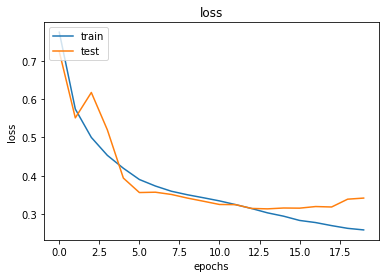

In [66]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()['parameters']

In [44]:
model_2= tf.keras.Sequential([
     layers.Conv1D(64, (3), activation='relu', padding="same"),
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     layers.Conv1D(1, (3), activation='relu', padding="same"),
     layers.Lambda( lambda x: K.sum(x, axis=1)),
 ])

model_2.compile(optimizer=optimizer,
              loss=loss)


In [45]:
history_2 = model_2.fit(train_dataset_norm,
          validation_data=(test_dataset_norm),
          epochs=15,
          verbose=1,
          #callbacks=[TestCallback((test_dataset)) ] )
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/15
67/67 [==============================] - 21s 308ms/step - loss: 0.7397 - val_loss: 0.0000e+00
Epoch 2/15
67/67 [==============================] - 19s 280ms/step - loss: 0.6459 - val_loss: 0.6193
Epoch 3/15
67/67 [==============================] - 18s 263ms/step - loss: 0.6115 - val_loss: 0.5272
Epoch 4/15
67/67 [==============================] - 20s 292ms/step - loss: 0.4542 - val_loss: 0.4743
Epoch 5/15
67/67 [==============================] - 18s 270ms/step - loss: 0.4122 - val_loss: 0.4045

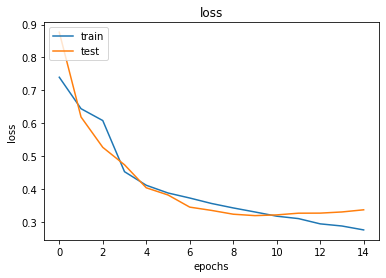

In [65]:
plt.figure()
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predictions on "model"

## Small values

In [67]:
nb_pred = 30
a = []
preds = []
trues = []
for i in (range(nb_pred)):
    t=np.array(X_val_norm)[i]
    t=t.reshape((1,max_blocks,nb_param))
    ex=tf.convert_to_tensor(t)
    pred = model.predict(ex)
    true = y_val[i]
    print()
    print(i)
    preds.append(pred)
    trues.append(true)
    print(f'pred : {pred}')
    print(f'true : {true}')
    a.append(loss(true,pred))
    print(f'loss : {loss(true,pred)}')

print()
print(f'loss : {np.mean(a)}')


0
pred : [[21.009434]]
true : [32.46180561]
loss : [[0.35279528]]

1
pred : [[27.19822]]
true : [40.3350812]
loss : [[0.32569321]]

2
pred : [[26.523613]]
true : [32.63593748]
loss : [[0.18728815]]

3
pred : [[43.193428]]
true : [50.77557453]
loss : [[0.14932665]]

4
pred : [[16.331627]]
true : [31.3181861]
loss : [[0.47852577]]

5
pred : [[16.790508]]
true : [23.81150526]
loss : [[0.29485734]]

6
pred : [[47.269173]]
true : [53.81573063]
loss : [[0.12164766]]

7
pred : [[35.217415]]
true : [37.08937631]
loss : [[0.05047163]]

8
pred : [[23.375217]]
true : [33.52623671]
loss : [[0.30277837]]

9
pred : [[40.033867]]
true : [53.12452875]
loss : [[0.24641464]]

10
pred : [[39.813324]]
true : [49.57019518]
loss : [[0.19682939]]

11
pred : [[52.030758]]
true : [54.59645851]
loss : [[0.0469939]]

12
pred : [[31.707184]]
true : [36.56941721]
loss : [[0.13295901]]

13
pred : [[37.928635]]
true : [37.91620371]
loss : [[0.00032785]]

14
pred : [[41.21292]]
true : [40.17378945]
loss : [[0.025865

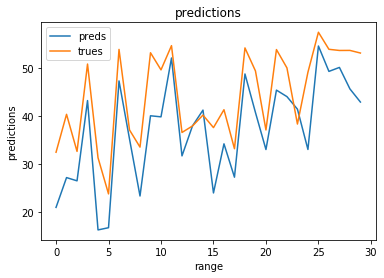

In [68]:

# summarize history for accuracy
plt.figure()
plt.plot(np.array(preds).reshape(nb_pred,-1))
plt.plot(np.array(trues).reshape(nb_pred,-1))
plt.title('predictions')
plt.ylabel('predictions')
plt.xlabel('range')
plt.legend(['preds', 'trues'], loc='upper left')
plt.show()


In [ ]:
%pycache

df_preds =pd.DataFrame( (np.array(preds).reshape(len(preds),-1))   )
df_trues=pd.DataFrame( (np.array(trues).reshape(len(trues),-1))   )

preds_unique = df_preds[0].unique()
preds_unique = np.sort(preds_unique)

trues_unique = df_trues[0].unique()
trues_unique=np.sort(trues_unique)

plt.plot(trues_unique)
plt.plot(preds_unique)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('range')
plt.legend(['preds', 'trues'], loc='upper left')
plt.show()

# Big values

In [69]:
nb_pred = 30
start = 12980
a = []
preds = []
trues = []
for i in (range(start, start+nb_pred)):
    t=np.array(X_val_norm)[i]
    t=t.reshape((1,max_blocks,nb_param))
    ex=tf.convert_to_tensor(t)
    pred = model.predict(ex)
    true = y_val[i]
    print()
    print(i)
    preds.append(pred)
    trues.append(true)
    print(f'pred : {pred}')
    print(f'true : {true}')
    a.append(loss(true,pred))
    print(f'loss : {loss(true,pred)}')

print()
print(f'loss : {np.mean(a)}')


12980
pred : [[2175.841]]
true : [2704.74507899]
loss : [[0.19554671]]

12981
pred : [[2239.164]]
true : [3358.67645218]
loss : [[0.33331951]]

12982
pred : [[2433.0974]]
true : [2991.76944195]
loss : [[0.18673632]]

12983
pred : [[2047.7683]]
true : [2423.6327098]
loss : [[0.15508307]]

12984
pred : [[2443.9324]]
true : [2762.99441948]
loss : [[0.11547691]]

12985
pred : [[2051.6545]]
true : [2266.94903766]
loss : [[0.09497104]]

12986
pred : [[2300.6394]]
true : [2671.68863222]
loss : [[0.13888191]]

12987
pred : [[2338.4827]]
true : [2723.08382079]
loss : [[0.14123735]]

12988
pred : [[2344.1294]]
true : [2727.38350821]
loss : [[0.1405208]]

12989
pred : [[1863.5356]]
true : [1892.26260787]
loss : [[0.01518128]]

12990
pred : [[2381.3066]]
true : [2705.32113638]
loss : [[0.11976933]]

12991
pred : [[2182.2634]]
true : [2192.58565072]
loss : [[0.00470779]]

12992
pred : [[2445.9421]]
true : [2787.09917458]
loss : [[0.12240578]]

12993
pred : [[2163.5183]]
true : [3582.8398406]
loss 

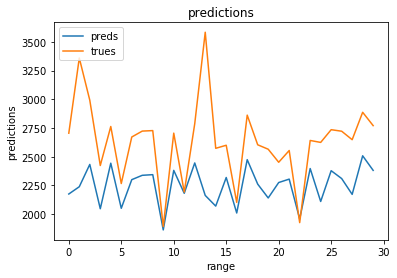

In [70]:

# summarize history for accuracy
plt.figure()
plt.plot(np.array(preds).reshape(nb_pred,-1))
plt.plot(np.array(trues).reshape(nb_pred,-1))
plt.title('predictions')
plt.ylabel('predictions')
plt.xlabel('range')
plt.legend(['preds', 'trues'], loc='upper left')
plt.show()


In [ ]:
# 

In [72]:
# Example
input_shape  = (1, 37, 13) 
x = tf.random.normal(input_shape) 
model= tf.keras.Sequential([
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     # inverted conv block?
     layers.Conv1D(32*2, (1), activation='relu', padding="same"),
     layers.Conv1D(32*2, (3), activation='relu', padding="same"),
     layers.Conv1D(1, (1), activation='relu', padding="same"),
     layers.Lambda( lambda x: K.sum(x, axis=1)),
 ])



y = model(x) 
print(y.shape) 

(1, 37, 1)
